In [1]:
import sys
sys.path.insert(1, '/home/BCCRC.CA/ssubedi/projects/experiments/asapp/asapp/')

from util._io import read_config
from collections import namedtuple
from pathlib import Path
import pandas as pd
import numpy as np
import logging
from scannotation import ASAPP
from data._dataloader import DataSet
from util import _topics


import matplotlib.pylab as plt
import seaborn as sns
import colorcet as cc

from data import _sim 
from scipy import stats
from sklearn.metrics import mean_squared_error as mse

import joblib

experiment = '/projects/experiments/asapp/'
server = Path.home().as_posix()
experiment_home = server+experiment
experiment_config = read_config(experiment_home+'config.yaml')
args = namedtuple('Struct',experiment_config.keys())(*experiment_config.values())

dl = DataSet()
dl.config = args
dl.initialize_path()
dl.initialize_data()
# dl.load_data()
print(dl.inpath)
print(dl.outpath)
# logging.basicConfig(filename=dl.outpath+'_model.log',
# 						format='%(asctime)s %(levelname)-8s %(message)s',
# 						level=logging.INFO,
# 						datefmt='%Y-%m-%d %H:%M:%S')

# asap = ASAPP(adata=dl,tree_min_leaf=5,tree_max_depth=1000, factorization='MVB',max_iter=10,n_pass=10)
# asap.factorize()
# asap.save_model()

/home/BCCRC.CA/ssubedi/projects/experiments/asapp/data/tcell/tcell
/home/BCCRC.CA/ssubedi/projects/experiments/asapp/result/tcell/tcell


In [2]:
asap = joblib.load(dl.outpath+'_model_vb.pkl')

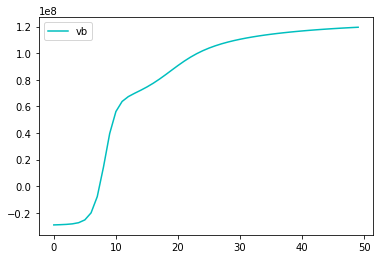

In [3]:
plt.plot(asap.llk,'c',label='vb')
plt.legend()

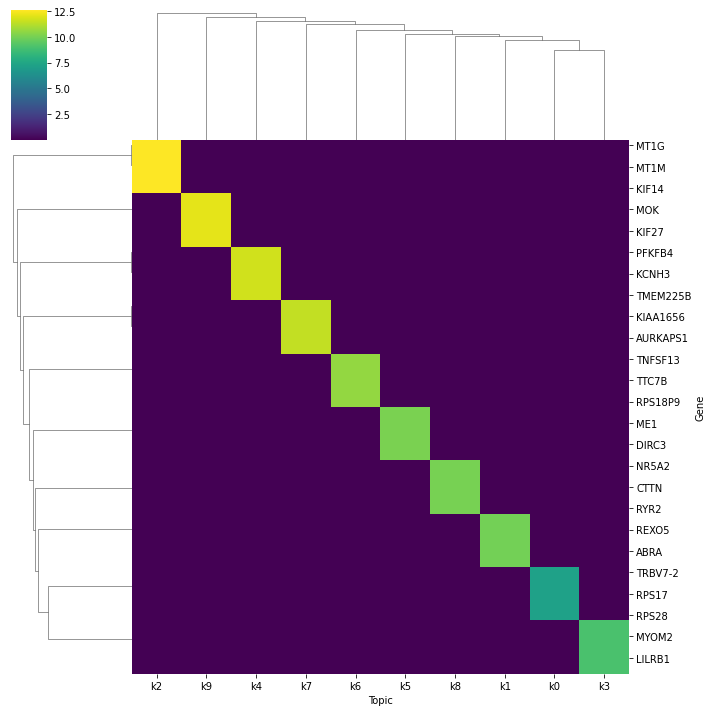

In [4]:
df_beta = pd.DataFrame(asap.Ebeta)
df_beta.columns = dl.cols
df_top = _topics.get_topic_top_genes(df_beta.iloc[:,:],top_n=5)
df_top = df_top.pivot(index='Topic',columns='Gene',values='Proportion')
sns.clustermap(df_top.T,cmap='viridis')

In [18]:
df_pl = pd.read_csv(dl.outpath+'_prior_label.csv.gz',sep='\t')
df_pl = df_pl[['cellID','meta.cluster']]
df_pl.columns = ['cell','cell_type']
df_pl

,cell,cell_type
0,CHOL.NTH103.0216,CD4.c10.Tm.CAPG
1,CHOL.NTH106.0216,CD4.c12.Tem.GZMK
2,CHOL.NTH107.0216,CD4.c12.Tem.GZMK
3,CHOL.NTH108.0216,CD4.c03.Tn.ADSL
4,CHOL.NTH111.0216,CD4.c06.Tm.ANXA1
...,...,...
184450,TTTGGTTTCGACCAGC.31,CD8.c10.Trm.ZNF683
184451,TTTGTCAAGTCTTGCA.31,CD8.c02.Tm.IL7R
184452,TTTGTCAAGTGTACGG.31,CD8.c06.Tem.GZMK
184453,TTTGTCATCAACGGCC.31,CD8.c04.Tm.CD52


In [12]:
df_theta = pd.DataFrame(asap.predicted_params['theta_a']/asap.predicted_params['theta_b'])
df_theta.to_csv(dl.outpath+'_model_theta.csv.gz')

In [45]:
import umap

df_theta = pd.DataFrame(asap.predicted_params['theta_a']/asap.predicted_params['theta_b'])
df_umap= pd.DataFrame()
df_umap['cell'] = [x.split('_')[0]for x in dl.rows]
df_umap['topic'] = [x for x in df_theta.iloc[:,1:].idxmax(axis=1)]

umap_2d = umap.UMAP(n_components=2, init='random', random_state=0,min_dist=0.0,metric='cosine')
proj_2d = umap_2d.fit(df_theta.iloc[:,1:])
df_umap[['umap1','umap2']] = umap_2d.embedding_[:,[0,1]]
df_umap


# df_umap = pd.read_csv(dl.outpath+'_umap.csv')
# df_umap = df_umap.rename(columns={'Unnamed: 0':'cell','V1':'umap1','V2':'umap2'})
# df_umap['cell'] = dl.rows
# df_umap['topic'] = [x for x in df_theta.iloc[:,1:].idxmax(axis=1)]

# df_umap

,cell,topic,umap1,umap2
0,GTACGTACAATGGTCT.2,1,3.947403,-1.523491
1,TGAGCCGCAAAGTGCG.4,6,2.473488,2.459488
2,CTAGTGACAGTATGCT.3,8,4.932098,4.650244
3,TCGTAGAAGACTTTCG.4,8,1.673515,4.258188
4,ACATCAGTCACCTTAT.2,2,7.041061,11.842875
...,...,...,...,...
45080,CHOL.T92.0216,3,10.049045,4.478343
45081,CHOL.T93.0216,1,3.593647,6.939031
45082,CHOL.T95.0216,5,4.902903,0.557900
45083,CHOL.T97.0216,8,1.544200,4.200513


In [55]:
# df_umap.to_csv(dl.outpath+'_umap.csv')
df_umap = pd.read_csv(dl.outpath+'_vb_umap.csv')

In [60]:
# df_umap = pd.read_csv(dl.outpath+'_umap.csv')
# df_umap['cell'] = dl.rows
df_join = pd.merge(df_umap,df_pl[['cell','cell_type']],on='cell',how='left')
# df_umap = df_umap[~df_umap['cell_type'].isna()]

# df_umap = df_umap.rename(columns={'Unnamed: 0':'cell','V1':'umap1','V2':'umap2'})
# df_umap['topic'] = [x for x in df_theta.iloc[:,1:].idxmax(axis=1)]
# df_join = df_join[df_join['cell_type'].str.contains('CD4')]
df_join


,cell,topic,umap1,umap2,cell_type
0,GTACGTACAATGGTCT.2,1,3.947403,-1.523491,CD4.c01.Tn.TCF7
1,TGAGCCGCAAAGTGCG.4,6,2.473488,2.459488,CD4.c10.Tm.CAPG
2,CTAGTGACAGTATGCT.3,8,4.932098,4.650244,CD4.c12.Tem.GZMK
3,TCGTAGAAGACTTTCG.4,8,1.673515,4.258188,CD4.c16.Tfh.CXCR5
4,ACATCAGTCACCTTAT.2,2,7.041061,11.842875,CD4.c20.Treg.TNFRSF9
...,...,...,...,...,...
45080,CHOL.T92.0216,3,10.049045,4.478343,CD8.c07.Temra.CX3CR1
45081,CHOL.T93.0216,1,3.593647,6.939031,CD8.c05.Tem.CXCR5
45082,CHOL.T95.0216,5,4.902903,0.557900,CD8.c02.Tm.IL7R
45083,CHOL.T97.0216,8,1.544200,4.200513,CD8.c12.Tex.CXCL13


In [61]:
df_join['cell_type'] = [ x.split('.')[0] + '_'+x.split('.')[2]for x in df_join['cell_type']]
df_join['cell_type'] = [ x if 'CD4' in x else 'CD8' for x in df_join['cell_type']]
df_join

,cell,topic,umap1,umap2,cell_type
0,GTACGTACAATGGTCT.2,1,3.947403,-1.523491,CD4_Tn
1,TGAGCCGCAAAGTGCG.4,6,2.473488,2.459488,CD4_Tm
2,CTAGTGACAGTATGCT.3,8,4.932098,4.650244,CD4_Tem
3,TCGTAGAAGACTTTCG.4,8,1.673515,4.258188,CD4_Tfh
4,ACATCAGTCACCTTAT.2,2,7.041061,11.842875,CD4_Treg
...,...,...,...,...,...
45080,CHOL.T92.0216,3,10.049045,4.478343,CD8
45081,CHOL.T93.0216,1,3.593647,6.939031,CD8
45082,CHOL.T95.0216,5,4.902903,0.557900,CD8
45083,CHOL.T97.0216,8,1.544200,4.200513,CD8


In [62]:
df_join.cell_type.value_counts()

CD8           23567
CD4_Tm         6919
CD4_Treg       5086
CD4_Tn         3845
CD4_Th17       1294
CD4_Tfh        1274
CD4_Temra       905
CD4_Tem         843
CD4_Mix         565
CD4_TfhTh1      533
CD4_ISG         254
Name: cell_type, dtype: int64

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 1.0, 'ASAP')

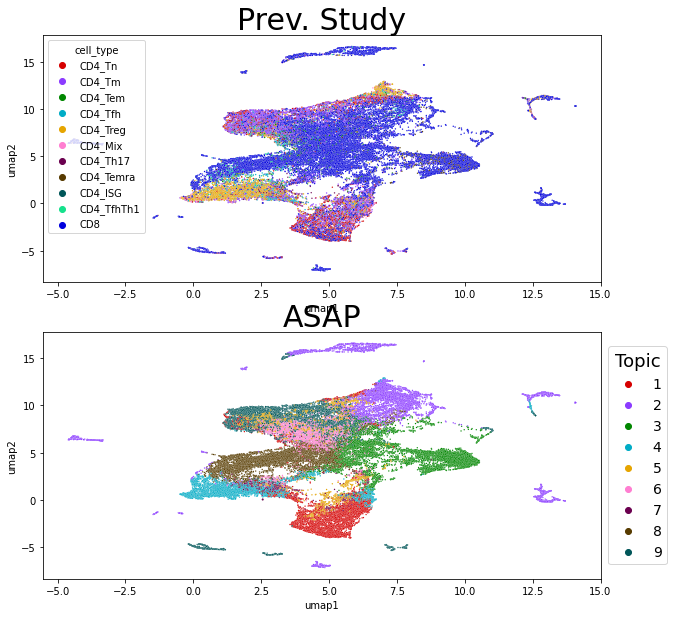

In [63]:
plt.rcParams["figure.figsize"] = (10,10)
figure,axis = plt.subplots(2,1)


cp = sns.color_palette(cc.glasbey_dark, n_colors=len(df_join['cell_type'].unique()))
p = sns.scatterplot(data=df_join, x='umap1', y='umap2', hue='cell_type',s=2,palette=cp,legend=True,ax=axis[0])
plt.legend(title='Topic',title_fontsize=18, fontsize=14,loc='center left', bbox_to_anchor=(1, 0.5))
p.axes.set_title("Prev. Study",fontsize=30)


cp = sns.color_palette(cc.glasbey_dark, n_colors=len(df_join['topic'].unique()))
p = sns.scatterplot(data=df_join, x='umap1', y='umap2', hue='topic',s=2,palette=cp,legend=True,ax=axis[1])
plt.legend(title='Topic',title_fontsize=18, fontsize=14,loc='center left', bbox_to_anchor=(1, 0.5))
p.axes.set_title("ASAP",fontsize=30)



Text(218.45454545454544, 0.5, 'cell_type')

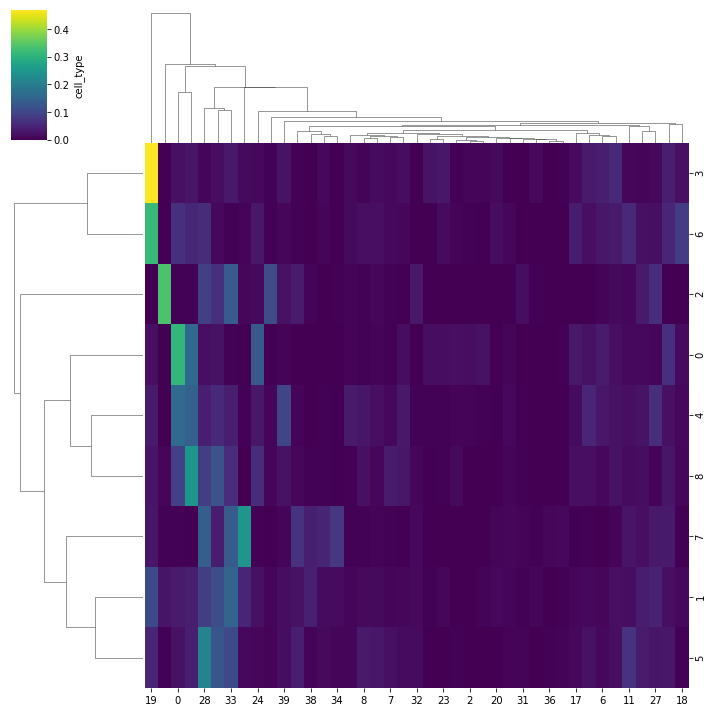

In [34]:
from sklearn.metrics.cluster import contingency_matrix
df_rmatch = pd.DataFrame(contingency_matrix(df_umap.topic,df_umap.cell_type))
# df_rmatch = pd.DataFrame(contingency_matrix(df_umap.topic_sc_ct,df_umap.topic_blk_ct))
df_rmatch = df_rmatch.div(df_rmatch.sum(axis=1), axis=0)
sns.clustermap(df_rmatch,cmap='viridis')
plt.xlabel('sc')
plt.ylabel('cell_type')


In [37]:
df_umap['cell_type'] = df_umap['cell_type2']

In [38]:
df_grp = df_umap.groupby(['topic','cell_type'])['cell_type'].size().rename('count').reset_index()
celltype_sum = dict(df_grp.groupby('topic')['count'].sum())
df_grp['ncount'] = [x/celltype_sum[y] for x,y in zip(df_grp['count'],df_grp['topic'])]
df_grp['topic'] =  df_grp['topic'].astype(int)
df_grp.to_csv(dl.outpath+'_r1_topic_ct_dist.csv.gz',index=False, compression='gzip')